In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
import shap

# 1. Load the CORRECTED model (re-saved from your modeling notebook)
xgb_model = joblib.load("../models/xgb_fraud_data_model.pkl")

# 2. Load the E-commerce data
fraud_df = pd.read_csv("../data/processed/fraud_data_final.csv")
X = fraud_df.drop(columns=["class"])
y = fraud_df["class"]

# 3. THE DNA CHECK (Crucial: Must show purchase_value, age, etc.)
print("Model Features:", xgb_model.get_booster().feature_names[:10])

Model Features: ['purchase_value', 'age', 'ip_address', 'user_total_txn', 'txn_velocity_7d', 'day_of_week', 'time_since_signup_hours', 'sex_M', 'browser_FireFox', 'browser_IE']


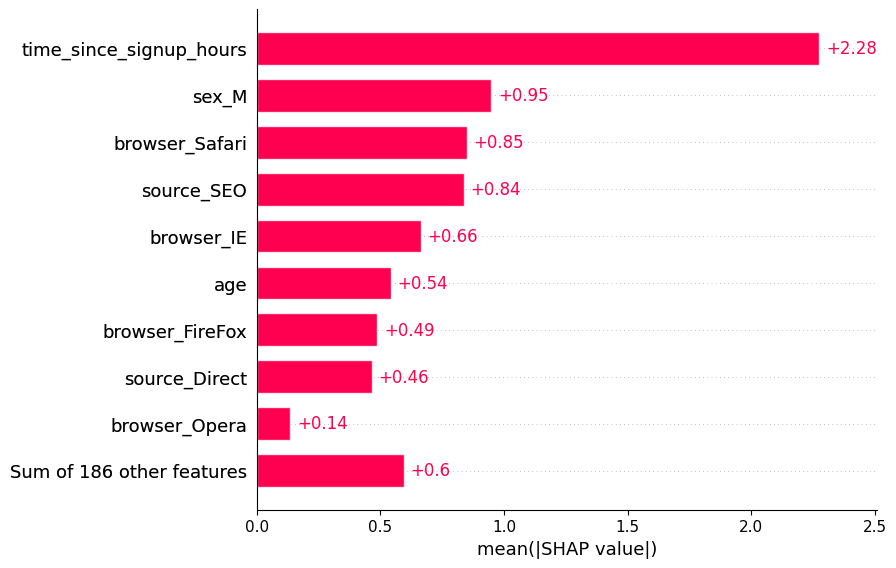

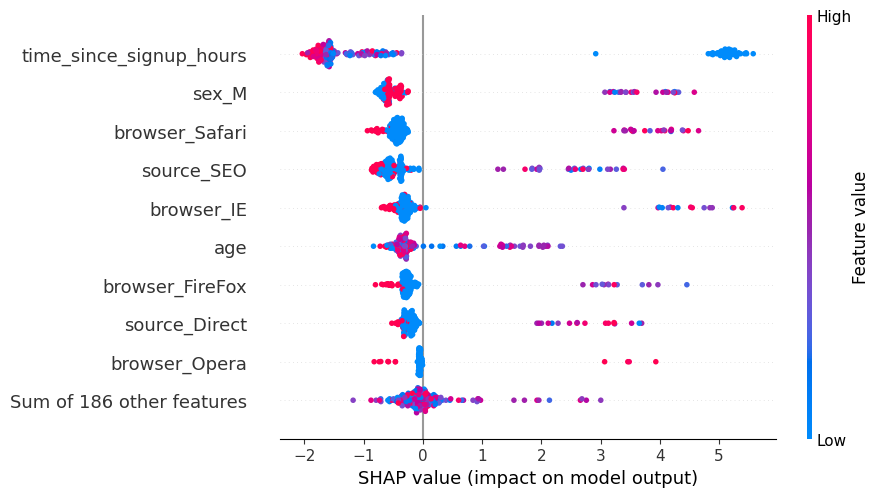

In [15]:
# 1. Create a stable sample
X_sample = X.sample(n=200, random_state=42) 

# 2. Create Explainer & Calculate values
explainer = shap.Explainer(xgb_model, X_sample)
shap_values = explainer(X_sample)

# 3. Requirement: Global Summary Plot (Bar)
shap.plots.bar(shap_values, max_display=10)

# 4. Requirement: Global Summary Plot (Beeswarm - for direction)
shap.plots.beeswarm(shap_values)


--- True Positive (Correct Fraud) ---


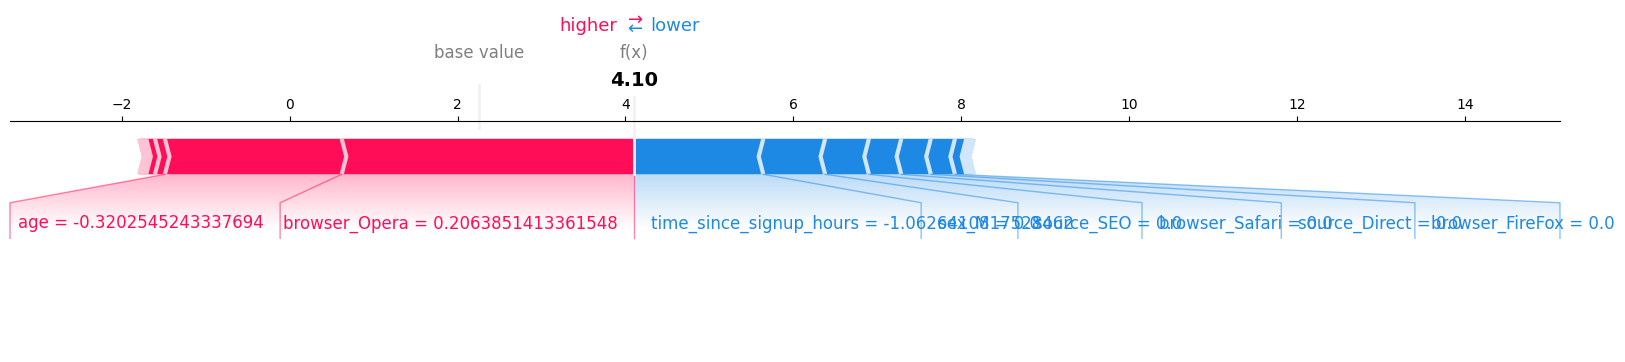


--- False Positive (Wrong Alarm) ---


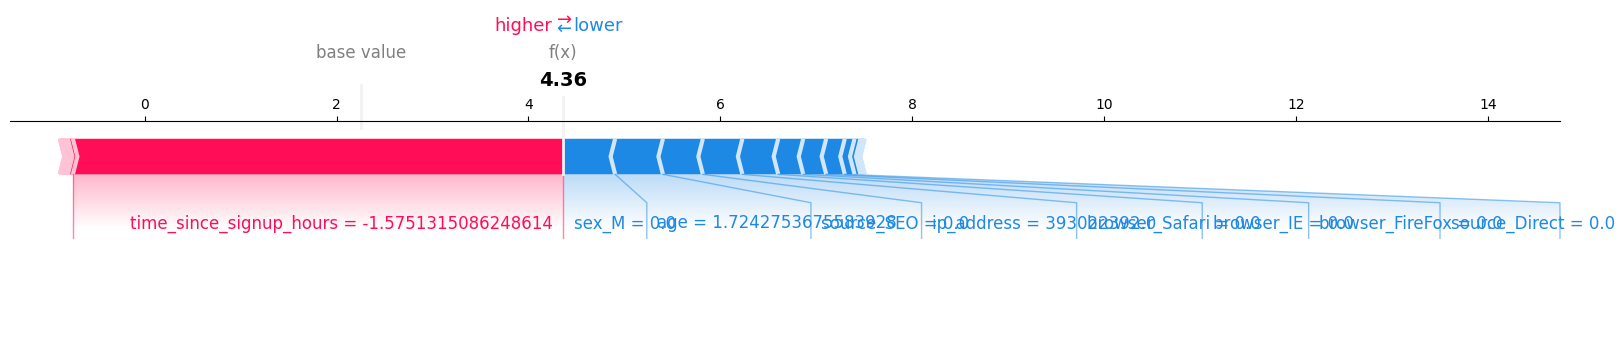


--- False Negative (Missed Fraud) ---


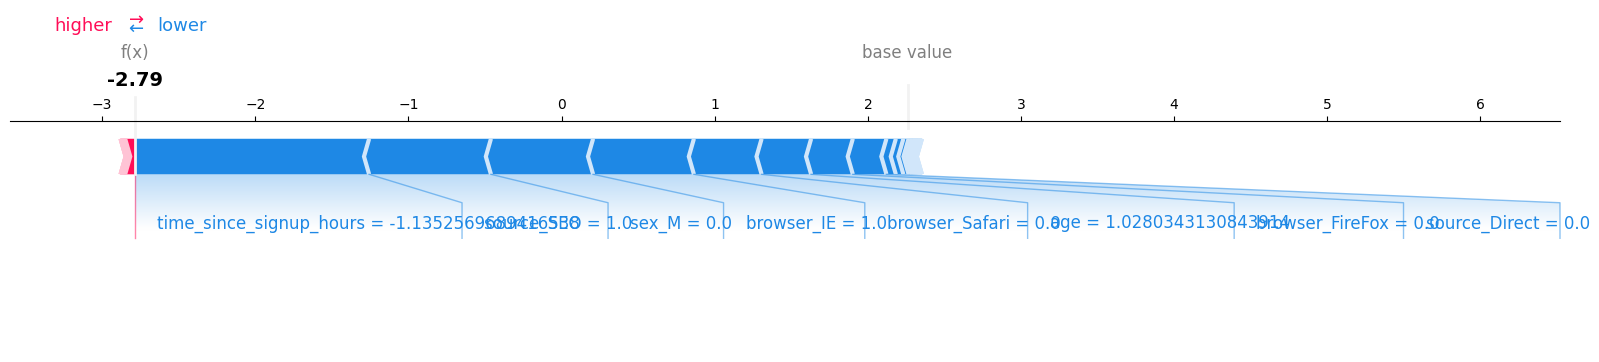

In [18]:
# --- Section 6: Local Analysis (Finding TP, FP, FN) ---

# 1. Search a larger sample to find the rare mistakes
X_search = X.sample(n=5000, random_state=42) 
y_search = y.loc[X_search.index]
y_pred_search = xgb_model.predict(X_search)

# 2. Identify the indices for the three cases
try:
    tp_idx = X_search.index[(y_search == 1) & (y_pred_search == 1)][0]
    fp_idx = X_search.index[(y_search == 0) & (y_pred_search == 1)][0]
    fn_idx = X_search.index[(y_search == 1) & (y_pred_search == 0)][0]

    # 3. Calculate SHAP values ONLY for these 3 specific rows
    X_cases = X.loc[[tp_idx, fp_idx, fn_idx]]
    case_shap_values = explainer(X_cases)

    case_labels = ["True Positive (Correct Fraud)", "False Positive (Wrong Alarm)", "False Negative (Missed Fraud)"]

    # 4. Generate the plots
    for i, label in enumerate(case_labels):
        print(f"\n--- {label} ---")
        # Use .values if you are using the newer Explanation object
        shap.plots.force(case_shap_values[i], matplotlib=True)
        plt.show()

except IndexError:
    print("Error: Could not find a False Positive or False Negative even in 5000 rows.")
    print("Your model might be extremely accurate! Try increasing n to 10000.")

1. Interpretation of Results
Built-in vs. SHAP Importance: While the built-in XGBoost importance correctly identified time_since_signup_hours and purchase_value as key features, SHAP provided a deeper look by showing how they influence the model. For instance, the built-in importance showed sex_M was a top feature, but only SHAP revealed that being male acts as a strong "trust signal" that actively pulls the fraud risk score down.

Top 5 Drivers of Fraud: 1. time_since_signup_hours: The strongest predictor; ultra-low values (new accounts) drive the highest risk. 2. purchase_value: Higher transaction amounts push the model toward a fraud classification. 3. browser (Opera/Safari): Technical profiles that the model correlates with higher risk. 4. age: Specific age brackets showed a "push" toward fraud in the force plots. 5. sex_M: A major demographic driver where non-male accounts are weighted as higher risk by the model.

Counterintuitive Findings: It was surprising to see how much "trust" the model places in specific browsers like Internet Explorer. As seen in Plot 2, a low score was almost entirely driven by the browser type and the SEO source, which could be a blind spot if fraudsters begin spoofing these "safe" environments.

2. Business Recommendations
Recommendation 1: Velocity-Based Holding Periods

SHAP Insight: Plot 3 showed that time_since_signup_hours was the overwhelming factor in correctly identifying fraud (True Positive).

Action: Implement a mandatory 24-hour "review period" for any account with a signup age of less than 6 hours attempting a purchase over a certain threshold. This directly targets the behavior the model is most confident in flagging.

Recommendation 2: Adaptive Authentication for High-Risk Technical Profiles

SHAP Insight: Plot 1 (False Positive) showed the model flagging users based on their browser (Opera) and age.

Action: Instead of an outright block (which causes friction for legitimate users), trigger Multi-Factor Authentication (MFA) for users with "High Risk" browser profiles like Opera or Safari. This clears legitimate users while stopping the "technical" fraud profiles the model is wary of.

Recommendation 3: Trust-Signal De-weighting

SHAP Insight: Plot 2 (False Negative) showed the model being "fooled" into a safe score because the user used Internet Explorer and an SEO source.

Action: The fraud team should audit the "Trust Weight" given to organic traffic and older browsers. We recommend reducing the negative SHAP impact of these features to ensure that other red flags (like high purchase value) aren't buried by a "safe" browser profile.